# Piąty starter 




Już bardzo dużo wycisnęliśmy, ale to nie jest koniec. Wyciśnijmy kolejny tysiąc (cel: zejdź poniżej 9k). 
Chociaż należy od razu powiedzieć, że nie jest to takie proste, ale działamy 💪 


*Początek jest podobny, jak w poprzednich starterach, wystarczy tylko odpalić i lecimy dalej ;)

### 👉 SCHEMAT DZIAŁANIA - 10 kroków do wykonania. 

1. Import bibliotek 
2. Wczytanie i połączenie danych
3. Wykorzystanie cech z poprzednich notebooków
4. Trenujemy model 
5. Szukamy nowych cech - eskperymentujemy 
6. Trenujemy model 
7. Szukamy nowych cech - eksperymentujemy
8. Trenujemy model 
9. Porównujemy z naszym ostatnim wynikiem
10. Wrzucamy na Kaggle, jeśli poprawiliśmy wynik 💪

Zaczynamy! 



## 1️ Importujemy biblioteki 

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
from tqdm import tqdm
import helper as h

import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error
import re

ModuleNotFoundError: No module named 'eli5'

In [ ]:
!pip3 install eli5

## 2️ Pobieramy i łączymy dane 

In [2]:
df_train = pd.read_hdf("../input/df.train.h5")
df_train["price_value"] = df_train['price_value'].map(h.parse_price)

df_test = pd.read_hdf("../input/df.test.h5")

print(df_train.shape, df_test.shape)

(80129, 10) (80129, 7)


In [ ]:
df = h.get_df(df_train, df_test)

In [4]:
cat_feats = [x for x in df.columns if "_cat" in x]
cat_feats

['Bezwypadkowy_cat',
 'Liczba miejsc_cat',
 'Kraj pochodzenia_cat',
 'Pojemność skokowa_cat',
 'Rodzaj paliwa_cat',
 'Skrzynia biegów_cat',
 'Możliwość finansowania_cat',
 'Pierwszy właściciel_cat',
 'Oferta od_cat',
 'Liczba drzwi_cat',
 'Przebieg_cat',
 'Moc_cat',
 'Metalik_cat',
 'Typ_cat',
 'Kolor_cat',
 'Model pojazdu_cat',
 'Stan_cat',
 'Kategoria_cat',
 'Serwisowany w ASO_cat',
 'Napęd_cat',
 'Leasing_cat',
 'Rok produkcji_cat',
 'Marka pojazdu_cat',
 'Faktura VAT_cat',
 'Pierwsza rejestracja_cat',
 'Zarejestrowany w Polsce_cat',
 'VAT marża_cat',
 'Wersja_cat',
 'VIN_cat',
 'Perłowy_cat',
 'Uszkodzony_cat',
 'Kod Silnika_cat',
 'Filtr cząstek stałych_cat',
 'Emisja CO2_cat',
 'Miesięczna rata_cat',
 'Liczba pozostałych rat_cat',
 'Opłata początkowa_cat',
 'Wartość wykupu_cat',
 'Akryl (niemetalizowany)_cat',
 'Tuning_cat',
 'Kierownica po prawej (Anglik)_cat',
 'Homologacja ciężarowa_cat',
 'Make_cat',
 'Metallic_cat',
 'Engine capacity_cat',
 'Version_cat',
 'VAT discount_cat'

## 3️ Cechy 
Wczytujemy cechy, które już znamy i wiemy, że nam pomagają (poprzednie notebooki). 

In [5]:
df["year_production"] = df["Rok produkcji"].astype(int)
df["year_production_ext"] = df.apply(lambda x: x["year_production"] if x["year_production"] != -1 else int(x["Year"]), axis=1)

df["version_years"] = df["Wersja"].map(lambda x: re.findall(r'(\d+)-(\d+)?', str(x)) )

df["version_year_from"] = df["version_years"].map(lambda x: x[0][0] if x else -1).astype(int)
df["version_year_to"] = df["version_years"].map(lambda x: x[0][1] if x and x[0][1] != "" else -1).astype(int)

## 4️ Тrenowanie modelu

In [6]:
feats = ["year_production_ext", "version_year_from", "version_year_to"] + cat_feats
#h.check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

## 5️ Poszukiwanie nowych cech & eskperymentowanie 

In [7]:
df["Pojemność skokowa"]

0         1 199 cm3
1         1 598 cm3
2         1 364 cm3
3         1 798 cm3
4         1 250 cm3
            ...    
160245    2 000 cm3
160246      998 cm3
160247    1 600 cm3
160251    1 560 cm3
160254    3 301 cm3
Name: Pojemność skokowa, Length: 160257, dtype: object

<AxesSubplot:>

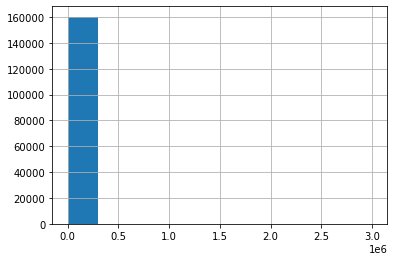

In [8]:
df["engine"] = df["Pojemność skokowa"].map(lambda x: str(x).split("cm3")[0].replace(" ", "")).astype("int")
df["engine"].hist()



Musimy trochę popracować z wartościami odstającymi. Milion to zbyt duża wartość. A co jeśli ustawimy `-1` dla wartości większych niż 99% (udajemy, że ich nie ma) 👀.

In [9]:
def reset_outlires(df, feat, prc=99):
    cut_value = np.percentile(df[feat], prc)
    
    return df[feat].map(lambda x: x if x < cut_value else -1)

Sprawdzamy, co się stało. 

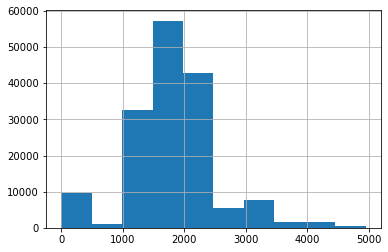

In [10]:
reset_outlires(df, "engine").hist();

df["engine_99"] = reset_outlires(df, "engine")

In [11]:
df["Moc"]

0         110 KM
1         117 KM
2          90 KM
3         160 KM
4          82 KM
           ...  
160245    170 KM
160246     69 KM
160247    105 KM
160251     92 KM
160254    174 KM
Name: Moc, Length: 160257, dtype: object

In [12]:
df["horse_power"] = df["Moc"].map(lambda x: str(x).split("KM")[0].replace(" ", "")).astype("int")

<AxesSubplot:>

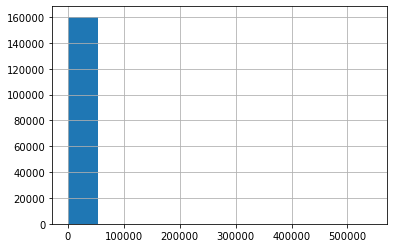

In [13]:
df["horse_power"].hist()

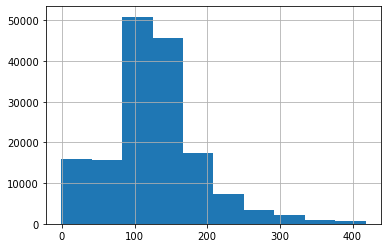

In [14]:
reset_outlires(df, "horse_power").hist();

df["horse_power_99"] = reset_outlires(df, "horse_power")

## 6️ Тrenujemy model

Dodajmy dwie nowe cechy i przekonajmy się, na ile nam to pomoże. 

In [15]:
feats = ["year_production_ext", "version_year_from", "version_year_to"] + cat_feats
feats += ["engine_99", "horse_power_99"]

#h.check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

## 7️ Poszukiwanie nowych cech & eskperymentowanie 🤖

Spróbuj posprawdzać jeszcze różne rzeczy. Może coś Ci przyszło ciekawego do głowy? Jak nie sprawdzisz, to się nie dowiesz, czy to ma sens. 

## 8️ Тrenujemy model 

Jak uda Ci się znaleźć ciekawą cechę, to sprawdź, jak wpływa na model. Analogicznie jak zrobilismy to wspólnie w poprzednich krokach. 


<AxesSubplot:>

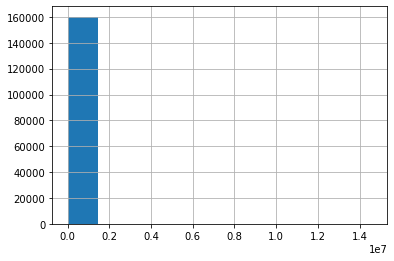

In [16]:
##twoje eksperymenty
#Dodajmy przebieg auta i wyświetlmy histogram
#df["Przebieg"].unique()
df["mileage"] = df["Przebieg"].map(lambda x: str(x).split("km")[0].replace(" ", "")).astype("int")
df["mileage"].hist()

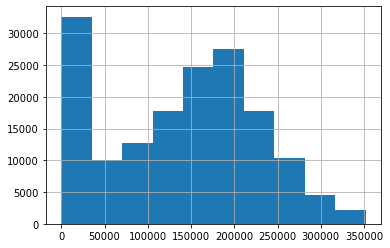

In [17]:
reset_outlires(df, "mileage").hist();

df["mileage_99"] = reset_outlires(df, "mileage")

In [18]:
feats += ["mileage_99"]

In [29]:
#Sprawdzamy poszczególne cechy i ich wpływ na wynik
#df["Miesięczna rata"].unique()
#df["monthly_fee"] = df["Miesięczna rata"].map(lambda x: str(x).split("PLN")[0].replace(" ", "").replace(",", ".")).astype("float")
#df["monthly_fee"].hist()
#df["monthly_fee"].unique()
#df["Opłata początkowa"].unique()
#df["initial_fee"] = df["Opłata początkowa"].map(lambda x: str(x).split("PLN")[0].replace(" ", "").replace(",", ".")).astype("float")
#df["initial_fee"].unique()
#df["Wartość wykupu"].unique()
#df["initial_fee"] = df["Wartość wykupu"].map(lambda x: str(x).split("PLN")[0].replace(" ", "").replace(",", ".")).astype("float")
#df["initial_fee"].hist()
#df["initial_fee"].hist(bins=100)
#df["Engine power"].unique()
#df["engine_power"] = df["Engine power"].map(lambda x: str(x).split("HP")[0].replace(" ", "")).astype("int")
#df["engine_power"].unique()
#df["Engine capacity"].unique()
#df["engine_capacity"] = df["Engine capacity"].map(lambda x: str(x).split("cm3")[0].replace(" ", "")).astype("int")
#df["engine_capacity"].unique()
df["ASO"] = df['Serwisowany w ASO'].apply(lambda x: 1 if x == 'Tak' else -1) #zamieniamy string "Tak' na int
df["ASO"].unique()

array([ 1, -1])

In [30]:
feats += ["ASO"]

In [31]:
##Trenujemy model CatBoost zamiast XGBoost
import catboost as cb
h.check_log_model(df, feats, cb.CatBoostRegressor(loss_function="RMSE"))
#(7489.644013312155, 156.54308722915144) - po zmianie algorytmu na catboost
#(7205.446022189184, 133.38113897681478) - po dodaniu mileage_99
#(7202.38656811062, 129.4522616912801) - "Vanila" CatBosstRegressor + cecha ASO
#(6810.332143484033, 149.9733267679511) - po tuningu hiperparametrów iterations=5000, learning_rate=0.03
#Ostatecznie załadowałem bez cechy "ASO" uzyskując wynik 6379.78448 - po tuningu hiperparametrów iterations = 15000, learning_rate=0.03

Learning rate set to 0.081851
0:	learn: 0.9708690	total: 10.9ms	remaining: 10.9s
1:	learn: 0.9132231	total: 68.5ms	remaining: 34.2s
2:	learn: 0.8594721	total: 100ms	remaining: 33.2s
3:	learn: 0.8118209	total: 116ms	remaining: 28.9s
4:	learn: 0.7684619	total: 193ms	remaining: 38.4s
5:	learn: 0.7299180	total: 204ms	remaining: 33.8s
6:	learn: 0.6948207	total: 292ms	remaining: 41.4s
7:	learn: 0.6626521	total: 303ms	remaining: 37.6s
8:	learn: 0.6333511	total: 373ms	remaining: 41s
9:	learn: 0.6060847	total: 398ms	remaining: 39.4s
10:	learn: 0.5811164	total: 413ms	remaining: 37.1s
11:	learn: 0.5598644	total: 492ms	remaining: 40.5s
12:	learn: 0.5403576	total: 502ms	remaining: 38.1s
13:	learn: 0.5219580	total: 588ms	remaining: 41.4s
14:	learn: 0.5056162	total: 598ms	remaining: 39.3s
15:	learn: 0.4905022	total: 656ms	remaining: 40.3s
16:	learn: 0.4777118	total: 692ms	remaining: 40s
17:	learn: 0.4661866	total: 703ms	remaining: 38.3s
18:	learn: 0.4554452	total: 787ms	remaining: 40.6s
19:	learn: 0.

Weight,Feature
0.4411,year_production_ext
0.1111,horse_power_99
0.0736,Napęd_cat
0.0616,Marka pojazdu_cat
0.0516,engine_99
0.0396,mileage_99
0.0344,Typ_cat
0.0319,Skrzynia biegów_cat
0.0294,Uszkodzony_cat
0.0181,Model pojazdu_cat


In [32]:
feats

['year_production_ext',
 'version_year_from',
 'version_year_to',
 'Bezwypadkowy_cat',
 'Liczba miejsc_cat',
 'Kraj pochodzenia_cat',
 'Pojemność skokowa_cat',
 'Rodzaj paliwa_cat',
 'Skrzynia biegów_cat',
 'Możliwość finansowania_cat',
 'Pierwszy właściciel_cat',
 'Oferta od_cat',
 'Liczba drzwi_cat',
 'Przebieg_cat',
 'Moc_cat',
 'Metalik_cat',
 'Typ_cat',
 'Kolor_cat',
 'Model pojazdu_cat',
 'Stan_cat',
 'Kategoria_cat',
 'Serwisowany w ASO_cat',
 'Napęd_cat',
 'Leasing_cat',
 'Rok produkcji_cat',
 'Marka pojazdu_cat',
 'Faktura VAT_cat',
 'Pierwsza rejestracja_cat',
 'Zarejestrowany w Polsce_cat',
 'VAT marża_cat',
 'Wersja_cat',
 'VIN_cat',
 'Perłowy_cat',
 'Uszkodzony_cat',
 'Kod Silnika_cat',
 'Filtr cząstek stałych_cat',
 'Emisja CO2_cat',
 'Miesięczna rata_cat',
 'Liczba pozostałych rat_cat',
 'Opłata początkowa_cat',
 'Wartość wykupu_cat',
 'Akryl (niemetalizowany)_cat',
 'Tuning_cat',
 'Kierownica po prawej (Anglik)_cat',
 'Homologacja ciężarowa_cat',
 'Make_cat',
 'Metallic

## 9️,🔟  Porównanie wyniku i Kaggle submit
Na koniec zgodnie z tradyjcą, jeśli wynik jest lepszy niż nasz ostatni, to wrzucamy na Kaggle. 

In [28]:
feats = ["year_production_ext", "version_year_from", "version_year_to"] + cat_feats
feats += ["engine_99", "horse_power_99", "mileage_99"]

df_train = df[ ~df["price_value"].isnull() ].copy()
df_test = df[ df["price_value"].isnull() ].copy()

X_train = df_train[feats]
y_train = df_train["price_value"]
y_log_train = np.log(y_train)

X_test = df_test[feats]

#model = xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0)
model = cb.CatBoostRegressor(iterations=15000, learning_rate=0.03, loss_function="RMSE")
model.fit(X_train, y_log_train)
y_log_pred = model.predict(X_test)
y_pred = np.exp(y_log_pred)


df_test["price_value"] = y_pred
df_test[ ["id", "price_value"] ].to_csv("../output/xgb_log_year_production_engine_etc.csv", index=False)

0:	learn: 1.0108649	total: 57.2ms	remaining: 14m 17s
1:	learn: 0.9878663	total: 95.2ms	remaining: 11m 53s
2:	learn: 0.9661486	total: 109ms	remaining: 9m 2s
3:	learn: 0.9442354	total: 188ms	remaining: 11m 43s
4:	learn: 0.9235811	total: 200ms	remaining: 9m 58s
5:	learn: 0.9034539	total: 255ms	remaining: 10m 37s
6:	learn: 0.8841355	total: 295ms	remaining: 10m 32s
7:	learn: 0.8651260	total: 339ms	remaining: 10m 35s
8:	learn: 0.8471366	total: 395ms	remaining: 10m 57s
9:	learn: 0.8297704	total: 459ms	remaining: 11m 28s
10:	learn: 0.8126579	total: 492ms	remaining: 11m 10s
11:	learn: 0.7966820	total: 536ms	remaining: 11m 9s
12:	learn: 0.7811594	total: 590ms	remaining: 11m 20s
13:	learn: 0.7657814	total: 603ms	remaining: 10m 45s
14:	learn: 0.7512662	total: 692ms	remaining: 11m 30s
15:	learn: 0.7367022	total: 714ms	remaining: 11m 8s
16:	learn: 0.7227714	total: 788ms	remaining: 11m 34s
17:	learn: 0.7098928	total: 799ms	remaining: 11m 5s
18:	learn: 0.6972132	total: 886ms	remaining: 11m 38s
19:	lea

## 👀 Jak przedłużyć dostęp do serwera? 


26 września o godz. 23:59 kończy się konkurs na Kaggle, ale nie kończy się szansa na to, aby dalej eksperymentować z tymi danymi, a także skorzystać z innych materiałów, które już są dostępne i takich, które pojawia się. 

Dołączając do [DataWorkshop Club](https://dataworkshop.eu/dw-club) zachowujesz ten materiał i dostajesz trwały dostęp do konta (dopóki subskrybujesz). 




<a href="https://dataworkshop.eu/dw-club"><img src="../images/dwclub.png"></a>


## 🔥 Jeśli po raz pierwszy słyszysz o `DW Club`, oto kilka faktów na ten temat:

- Uczestnicy `DW Club` mają dostęp do materiałów 24/7
- `DW Club` ma mocniejszy serwer
- Ten master class to już kolejny materiał do którego uczestnicy `DW Club` mają dostęp, a co miesiąc ich liczba będzie tylko rosła - planujemy kolejne inicjatywy tego typu w ramach DW Club, także inną formę wsparcia w rozwoju. 

Uczestnicy `DW Club` mają zapewnione także korzystniejsze warunki zakupu płatnych kursów itp.
Dowiedz się więcej [klikając na link](https://dataworkshop.eu/dw-club).

# 📈 Nauka na kursach DataWorkshop 
 
Uczenie maszynowe to wciągający świat z ogromnymi możliwościami i perspektywami zawodowymi, ale początkującym łatwo jest zgubić się w tym świecie lub wpaść w czarne dziury. Jeśli chcesz rozwijać się zawodowo i wykorzystywać ML w swoej aktualnej pracy lub przyszłej, to rozważ intensywne szkolenie - 8 tygodni w ramach "Data Sciencce & Machine Learning w praktyce". Kurs jest 100% online. Dowiedz się o najbliższej edycji 👉 [tutaj](https://dataworkshop.eu/pl/practical-machine-learning) 
